In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.convolution import Gaussian2DKernel, convolve
import astropy.units as u
import pandas as pd

import os
from tqdm import tqdm
import cv2
import pickle
import seaborn as sns
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
PATH = 'D:/Workshop/PhD/Data/ViaLactea/PPMAP_Results/'
model = tf.keras.models.load_model('D:/Workshop/PhD/Models/CNN for fbm Fields/32pxmodel')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)         0     

In [3]:
progress_df = pd.read_csv('D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/progress.csv')
progress_df

Direction
0       l000
1       l002
2       l004
3       l006
4       l008
5       l011
6       l013
7       l015
8       l017
9       l019
10      l022
11      l024
12      l026
13      l028
14      l030
15      l033
16      l035
17      l037
18      l039
19      l041
20      l044
21      l046
22      l048
23      l050
24      l052
25      l055
26      l057
27      l059
28      l061
29      l063
30      l066
31      l068
32      l070
33      l072
34      l074
35      l077
36      l079
37      l081
38      l083
39      l085
40      l088
41      l090
42      l092
43      l094
44      l096
45      l099

In [4]:
coords_list = []
H_list = []
S_list = []
N_p=64

for folder in tqdm(os.listdir(PATH)):
    direction = folder[1:4]
    if not (progress_df['Direction']==f'l{direction}').any():
        hdu = fits.open(f'{PATH}{folder}/l{direction}_cdens.fits')[0]
        wcs = WCS(hdu.header)
        array = hdu.data
        global_mask = np.where(np.isnan(array), 0, 1)
        
        H_array = []
        S_array = []
        for y in np.arange(np.shape(array)[1]):
            X = []
            for x in np.arange(np.shape(array)[0]):
                sub_field = array[int(x-N_p/2):int(x+N_p/2),int(y-N_p/2):int(y+N_p/2)]
                if np.shape(sub_field) == (N_p,N_p):

                    sub_field = sub_field/np.nanmax(sub_field) * 255
                    sub_field = np.uint8(sub_field)
                    mask = np.uint8(np.isnan(sub_field))

                    sub_field = cv2.inpaint(sub_field,mask,3,cv2.INPAINT_TELEA)
                    sub_field = cv2.resize(sub_field,(32,32))

                    m_1_field = np.mean(sub_field)
                    s_1_field = np.std(sub_field)
                    m_2_field = 0
                    s_2_field = 1/4

                    sub_field = sub_field * s_2_field/s_1_field
                    sub_field += (m_2_field-m_1_field*s_2_field/s_1_field)
                    sub_field[np.where(sub_field>1.)] = 1.
                    sub_field[np.where(sub_field<-1.)] = -1.
                    sub_field = (sub_field-np.min(sub_field))/(np.max(sub_field)-np.min(sub_field))

                    sub_field = np.array(sub_field).reshape(32, 32, 1)
                    X.append(sub_field)

            if len(X) != 0:
                X=np.asarray(X)
                predictions = model.predict(X)
                H_array.append(predictions[:,0])
                S_array.append(predictions[:,1])

        H_array = np.asarray(H_array).T
        S_array = np.asarray(S_array).T
        np.savetxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/H/raw_data/{direction}.txt',H_array)
        np.savetxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/S/raw_data/{direction}.txt',S_array)
        
        H_count_array = np.zeros(np.shape(array))
        H_sum_array = np.zeros(np.shape(array))
        H_weight_array = np.zeros(np.shape(array))
        mask = global_mask[int(N_p/2):-int(N_p/2)+1,int(N_p/2):-int(N_p/2)+1]
        for y_i in np.arange(np.shape(H_array)[1]):
            for x_i in np.arange(np.shape(H_array)[0]):
                H_weight_array[x_i:x_i+N_p,y_i:y_i+N_p] += mask[x_i,y_i] 
                H_count_array[x_i:x_i+N_p,y_i:y_i+N_p]+=1
                H_sum_array[x_i:x_i+N_p,y_i:y_i+N_p]+=H_array[x_i,y_i]

        H_weight_array = np.where(H_weight_array>=N_p**2, 1, 0)
        H_avg_array = H_sum_array/H_count_array * H_weight_array
        
        S_count_array = np.zeros(np.shape(array))
        S_sum_array = np.zeros(np.shape(array))
        S_weight_array = np.zeros(np.shape(array))
        mask = global_mask[int(N_p/2):-int(N_p/2)+1,int(N_p/2):-int(N_p/2)+1]
        for y_i in np.arange(np.shape(S_array)[1]):
            for x_i in np.arange(np.shape(S_array)[0]):
                S_weight_array[x_i:x_i+N_p,y_i:y_i+N_p] += mask[x_i,y_i] 
                S_count_array[x_i:x_i+N_p,y_i:y_i+N_p]+=1
                S_sum_array[x_i:x_i+N_p,y_i:y_i+N_p]+=S_array[x_i,y_i]

        S_weight_array = np.where(S_weight_array>=N_p**2, 1, 0)
        S_avg_array = S_sum_array/S_count_array * S_weight_array
        
        np.savetxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/H/avg_data/{direction}.txt',H_avg_array)
        np.savetxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/S/avg_data/{direction}.txt',S_avg_array)

        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(H_avg_array)
        plt.contour(np.log10(array))
        plt.colorbar()
        plt.savefig(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/H/images/{direction}.png', bbox_inches='tight')
        plt.close()

        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(S_avg_array)
        plt.contour(np.log10(array))
        plt.colorbar()
        plt.savefig(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/S/images/{direction}.png', bbox_inches='tight')
        plt.close()
        
        mean_H = np.mean(H_avg_array)
        std_H = np.std(H_avg_array)
        H_avg_array = (H_avg_array-mean_H)/std_H

        mean_S = np.mean(S_avg_array)
        std_S = np.std(S_avg_array)
        S_avg_array = (S_avg_array-mean_S)/std_S
        
        img = np.log10(np.asarray(array))
        mask = np.uint8(np.isnan(img))
        img=cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)
        mean_img = np.nanmean(img)
        std_img = np.nanstd(img)
        img = (img-mean_img)/std_img
        
        data_cube = np.array([img,H_avg_array,S_avg_array])
    
        pickle_out = open(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/DataCubes/l{direction}.pickle','wb')
        pickle.dump(data_cube,pickle_out)
        pickle_out.close()    
        
        new_row = {'Direction':f'l{direction}'}
        progress_df = progress_df.append(new_row,ignore_index=True)
        progress_df.to_csv('D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/progress.csv',index=False)        

  0%|                                                                                          | 0/163 [00:00<?, ?it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
100%|███████████████████████████████████████████████████████████████████████████| 163/163 [53:33:06<00:00, 1182.74s/it]


In [ ]:
#### FIX DATA CUBES

PATH_64PX = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_fulltile/'
PATH_32PX = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/'
PATH = 'D:/Workshop/PhD/Data/ViaLactea/PPMAP_Results/'

for folder in tqdm(os.listdir(PATH)):
    ######## Image, Lat, Lon ########
    direction = folder[1:4]
    hdu = fits.open(f'{PATH}{folder}/l{direction}_cdens.fits')[0]
    wcs = WCS(hdu.header)
    image_array = hdu.data
    shape = np.shape(image_array)
    x = np.arange(0, shape[0])
    y = np.arange(0, shape[1])
    xx, yy = np.meshgrid(x, y)
    coords_grid = pixel_to_skycoord(xx,yy, wcs)
    lat = coords_grid.l.degree
    lon = coords_grid.b.degree
    ######### 32PX H and S ########
    H_avg_array = np.loadtxt(f'{PATH_32PX}H/avg_data/{direction}.txt')
    
    S_avg_array = np.loadtxt(f'{PATH_32PX}S/avg_data/{direction}.txt')
    
    data_cube = np.array([image_array,H_avg_array,S_avg_array,lat,lon])
    
    pickle_out = open(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/DataCubes/l{direction}.pickle','wb')
    pickle.dump(data_cube,pickle_out)
    pickle_out.close()
    
    ######### 64PX H and S ########
    H_avg_array = np.loadtxt(f'{PATH_64PX}H/avg_data/{direction}.txt')
    
    S_avg_array = np.loadtxt(f'{PATH_64PX}S/avg_data/{direction}.txt')
    
    data_cube = np.array([image_array,H_avg_array,S_avg_array,lat,lon])
    
    pickle_out = open(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_fulltile/DataCubes/l{direction}.pickle','wb')
    pickle.dump(data_cube,pickle_out)
    pickle_out.close()

In [3]:
hdus = [fits.open(f'{PATH}{folder}/{folder[:4]}_cdens.fits')[0] for folder in tqdm(os.listdir(PATH))]
hdu = hdus[0]

100%|███████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 693.51it/s]


In [4]:
N_p = 64

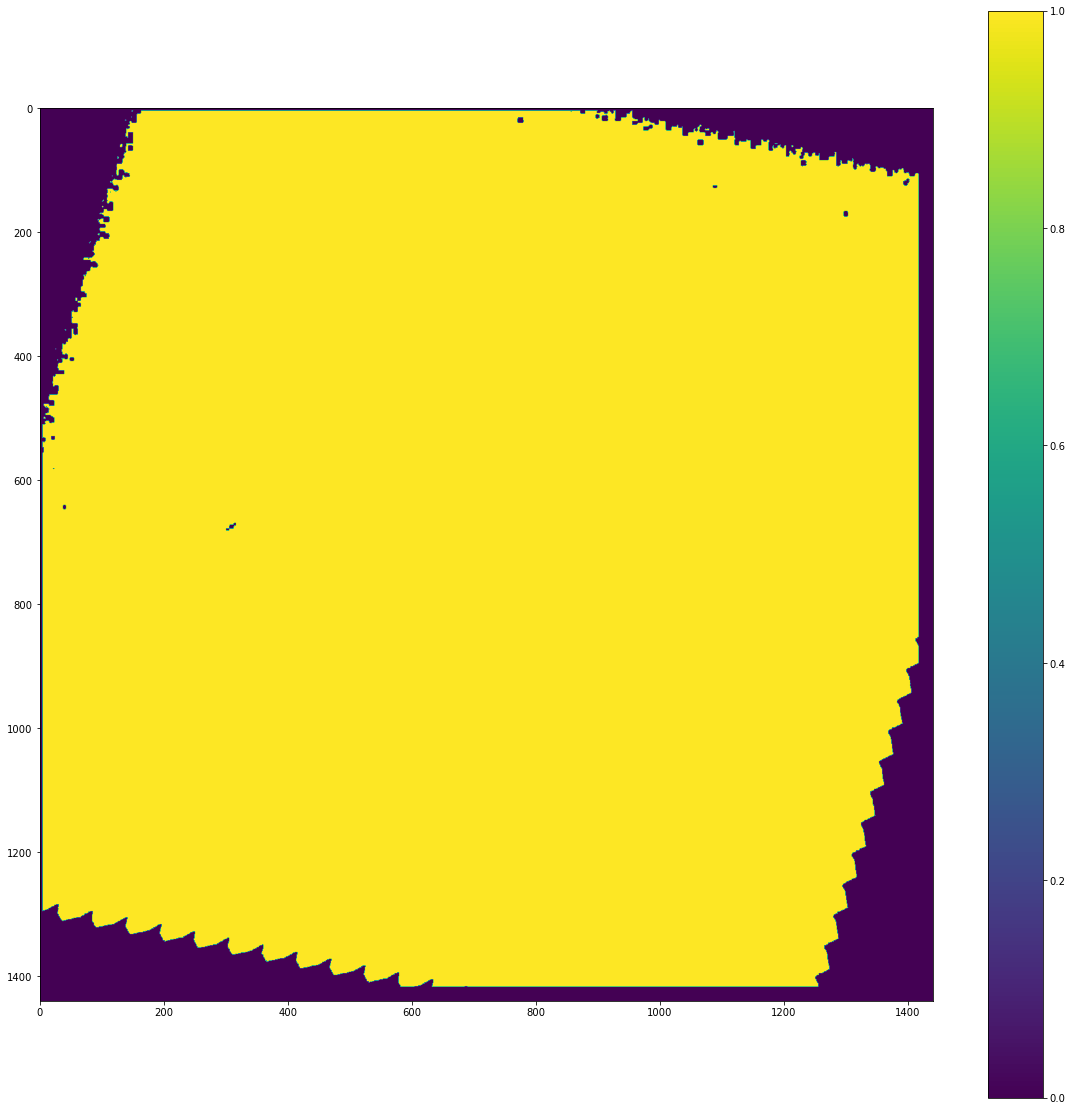

In [8]:
array = hdu.data
wcs = WCS(hdu.header)
global_mask = np.where(np.isnan(array), 0, 1)

In [10]:
H_array = []
S_array = []

for y in tqdm(np.arange(np.shape(array)[1])):
    X = []
    for x in np.arange(np.shape(array)[0]):
        sub_field = array[int(x-N_p/2):int(x+N_p/2),int(y-N_p/2):int(y+N_p/2)]
        if np.shape(sub_field) == (N_p,N_p):
            
            sub_field = sub_field/np.nanmax(sub_field) * 255
            sub_field = np.uint8(sub_field)
            mask = np.uint8(np.isnan(sub_field))

            sub_field = cv2.inpaint(sub_field,mask,3,cv2.INPAINT_TELEA)

            m_1_field = np.mean(sub_field)
            s_1_field = np.std(sub_field)
            m_2_field = 0
            s_2_field = 1/4

            sub_field = sub_field * s_2_field/s_1_field
            sub_field += (m_2_field-m_1_field*s_2_field/s_1_field)
            sub_field[np.where(sub_field>1.)] = 1.
            sub_field[np.where(sub_field<-1.)] = -1.
            sub_field = (sub_field-np.min(sub_field))/(np.max(sub_field)-np.min(sub_field))

            sub_field = np.array(sub_field).reshape(N_p, N_p, 1)
            X.append(sub_field)
            
    if len(X) != 0:
        X=np.asarray(X)
        predictions = model.predict(X)
        H_array.append(predictions[:,0])
        S_array.append(predictions[:,1])

H_array = np.asarray(H_array).T
S_array = np.asarray(S_array).T

  2%|█▋                                                                              | 30/1440 [00:01<00:51, 27.30it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: All-NaN slice encountered
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [37:49<00:00,  1.58s/it]


In [13]:
H_array.shape

(1377, 1377)

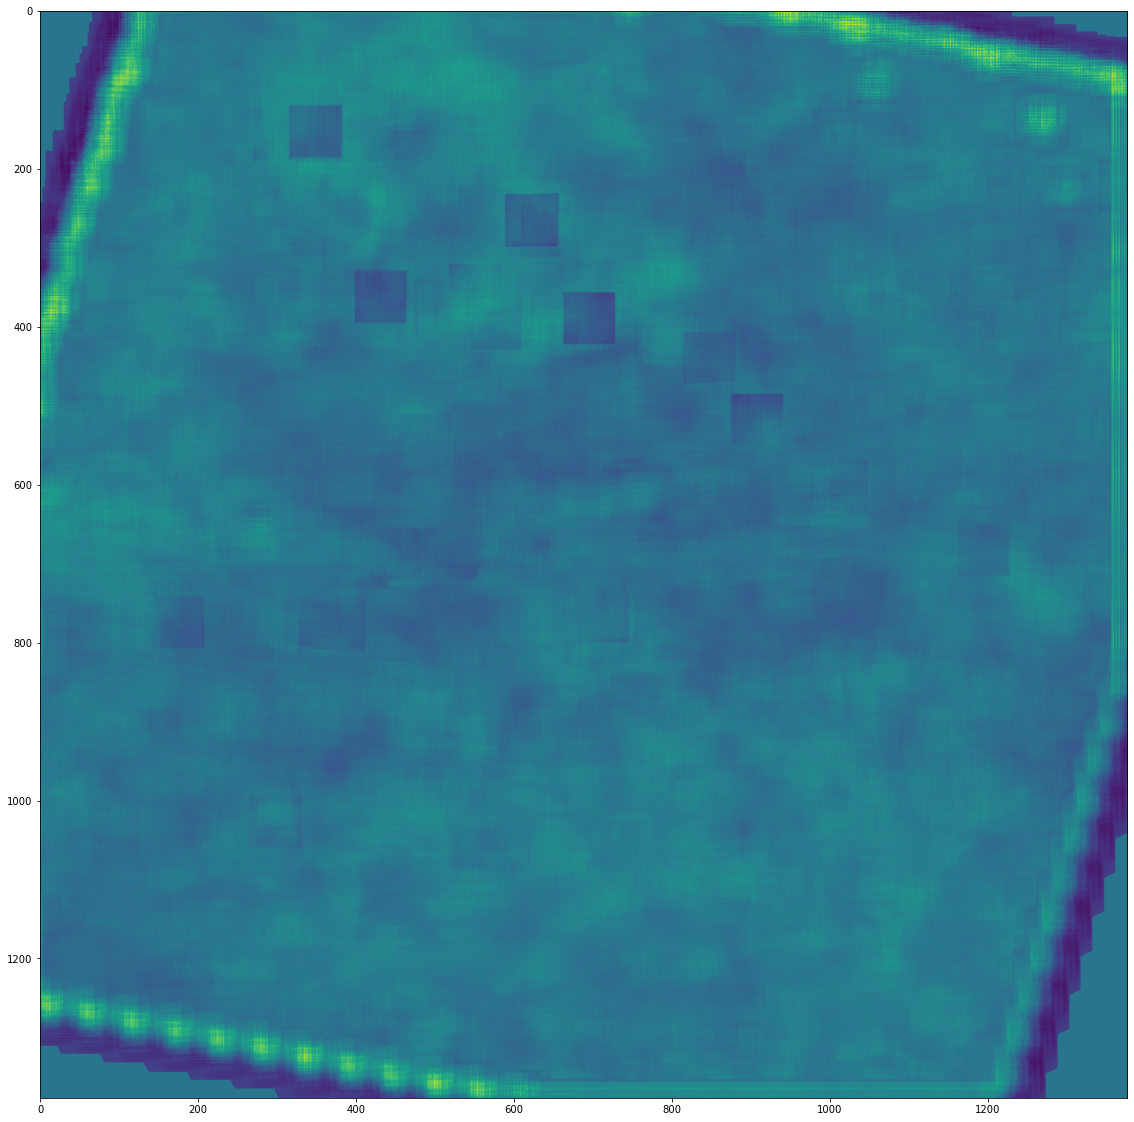

In [14]:
plt.figure(figsize=(10*2, 10*2))
plt.imshow(H_array)
plt.show()

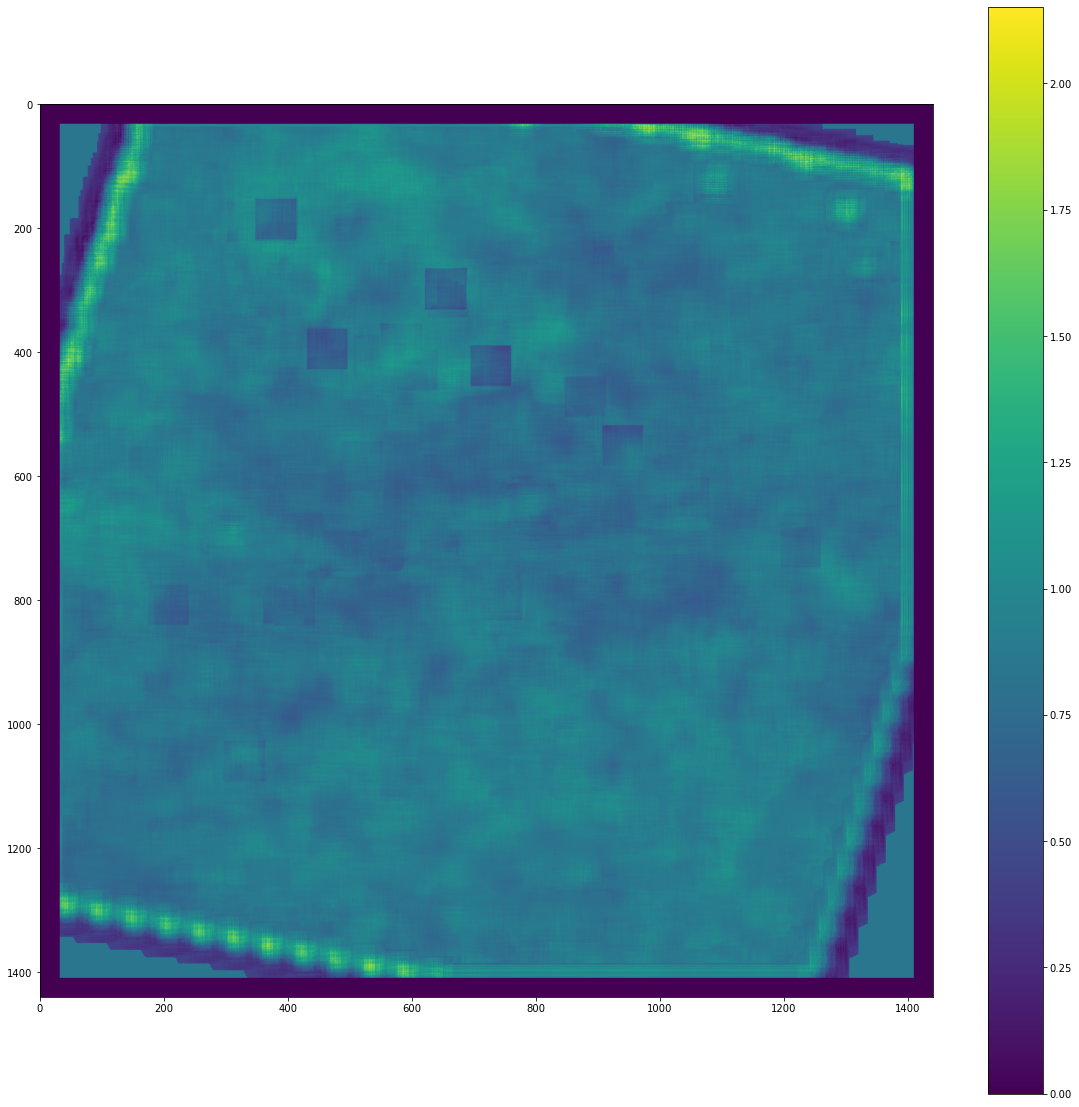

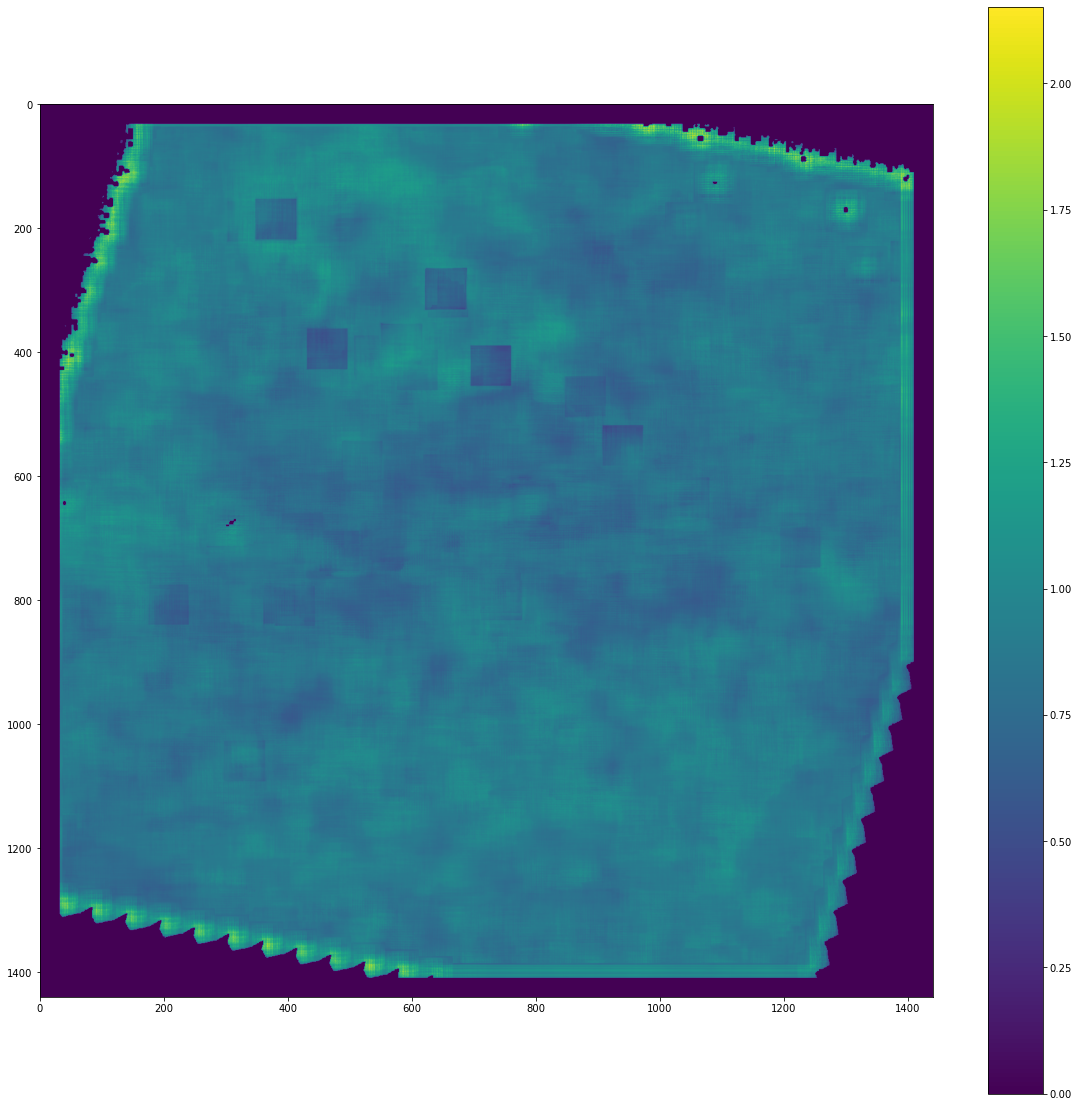

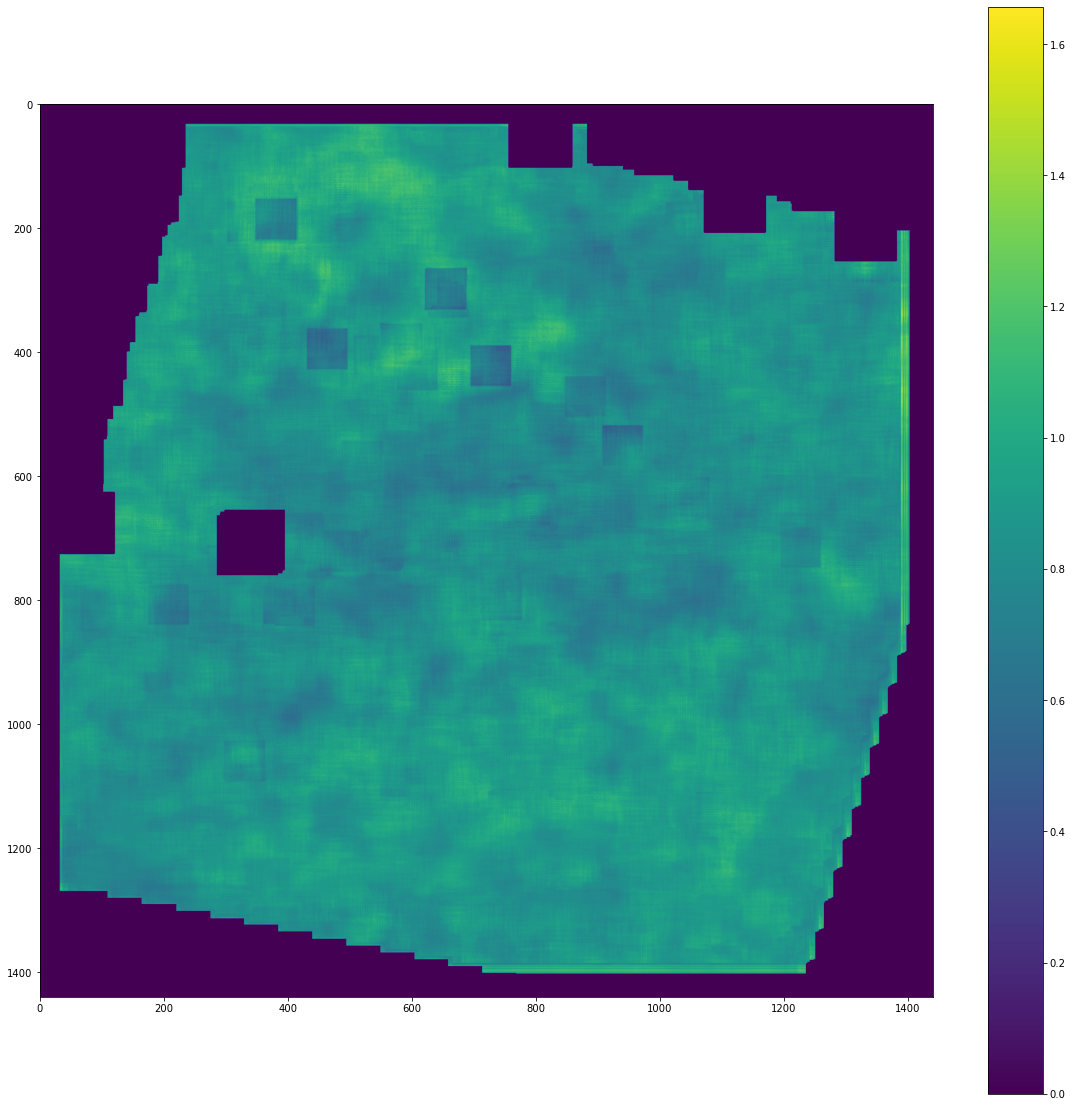

In [11]:
H_big = np.zeros(np.shape(array))
H_big[32:H_array.shape[0]+32,32:H_array.shape[0]+32] = H_array

plt.figure(figsize=(10*2, 10*2))
plt.imshow(H_big)
plt.colorbar()
plt.show()

plt.figure(figsize=(10*2, 10*2))
plt.imshow(H_big*global_mask)
plt.colorbar()
plt.show()

plt.figure(figsize=(10*2, 10*2))
plt.imshow(H_big*new_mask)
plt.colorbar()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 1377/1377 [03:13<00:00,  7.13it/s]


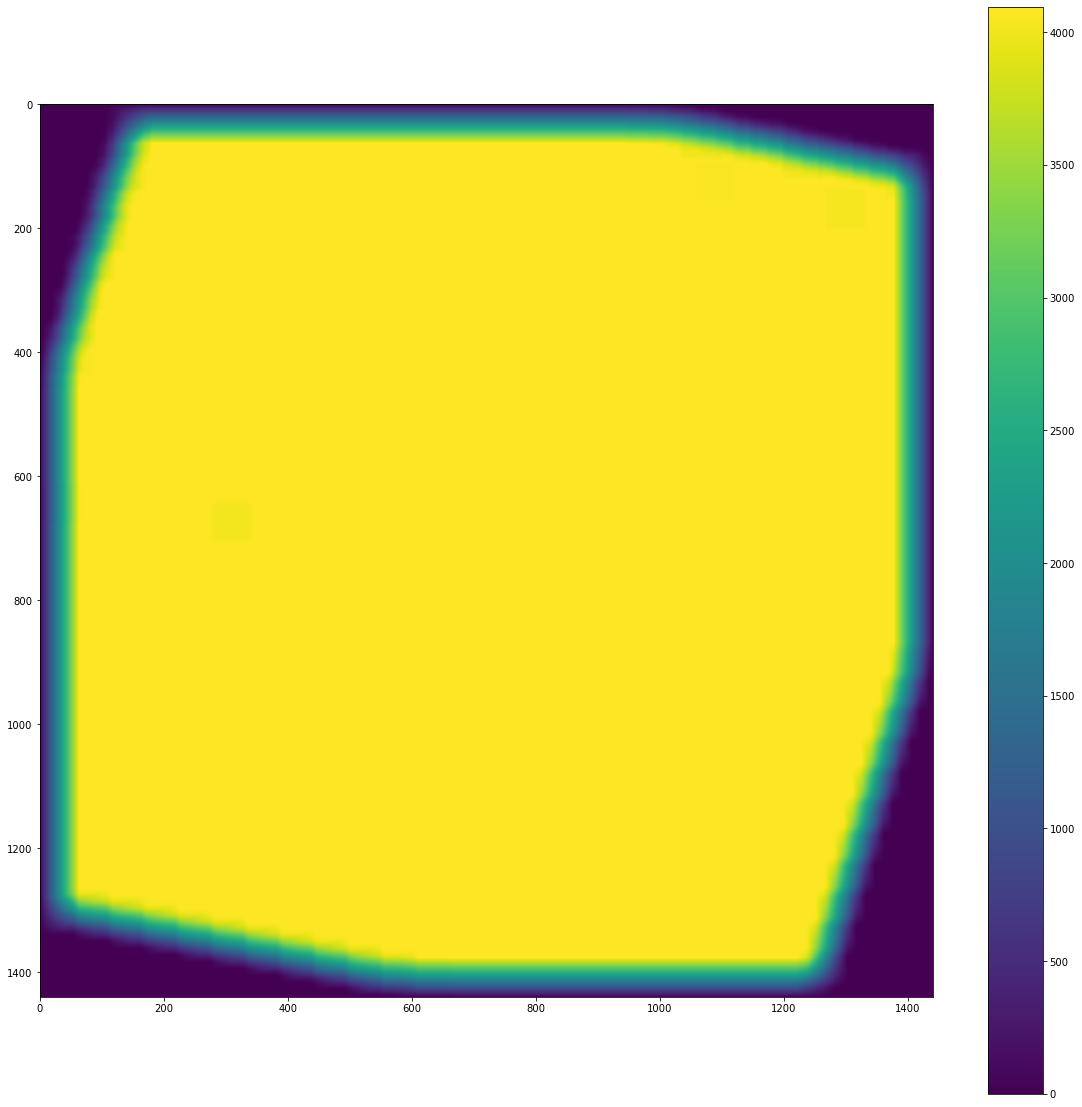

In [25]:
H_count_array = np.zeros(np.shape(array))
H_sum_array = np.zeros(np.shape(array))
H_weight_array = np.zeros(np.shape(array))
mask = global_mask[int(N_p/2):-int(N_p/2)+1,int(N_p/2):-int(N_p/2)+1]
for y_i in tqdm(np.arange(np.shape(H_array)[1])):
    for x_i in np.arange(np.shape(H_array)[0]):
        H_weight_array[x_i:x_i+N_p,y_i:y_i+N_p] += mask[x_i,y_i] 
        H_count_array[x_i:x_i+N_p,y_i:y_i+N_p]+=1
        H_sum_array[x_i:x_i+N_p,y_i:y_i+N_p]+=H_array[x_i,y_i]

H_weight_array = np.where(H_weight_array>=N_p**2, 1, 0)
H_avg_array = H_sum_array/H_count_array * H_weight_array

C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


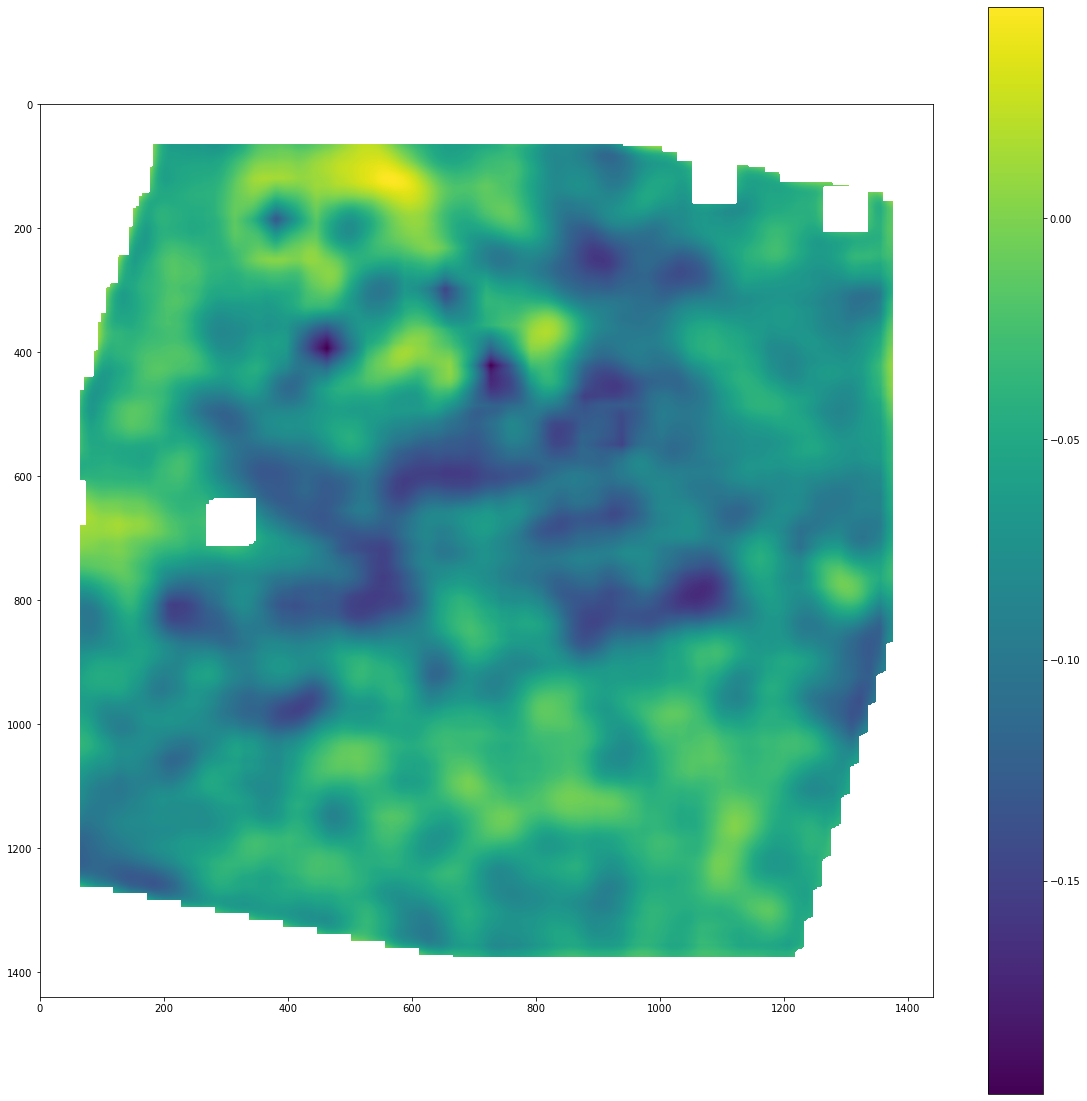

In [26]:
plt.figure(figsize=(10*2, 10*2))
plt.imshow(np.log10(H_avg_array))
plt.colorbar()
plt.show()